# DunnHumby Case

### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import shapiro, levene, kruskal
import statsmodels.api as sm
import scikit_posthocs as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import os

In [4]:
causal_data = pd.read_csv(r"C:\Users\Admin\Desktop\MSBA\Pred Modelling\Group Work\Datasets\causal_data.csv")
transaction_data = pd.read_csv(r"C:\Users\Admin\Desktop\MSBA\Pred Modelling\Group Work\Datasets\transaction_data.csv")
product = pd.read_csv(r"C:\Users\Admin\Desktop\MSBA\Pred Modelling\Group Work\Datasets\product.csv")

In [5]:
causal_data.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


In [6]:
product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [7]:
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


### Data Cleaning

#### Checking Null Values

In [10]:
print(transaction_data.isna().sum())
print(product.isna().sum())
print(causal_data.isna().sum())

household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dtype: int64
PRODUCT_ID              0
MANUFACTURER            0
DEPARTMENT              0
BRAND                   0
COMMODITY_DESC          0
SUB_COMMODITY_DESC      0
CURR_SIZE_OF_PRODUCT    0
dtype: int64
PRODUCT_ID    0
STORE_ID      0
WEEK_NO       0
display       0
mailer        0
dtype: int64


#### Checking Duplicates rows

In [12]:
trans_dupe = transaction_data[transaction_data.duplicated(keep = False)]
trans_dupe.shape

(0, 12)

In [13]:
prod_dupe = product[product.duplicated(keep = False)]
prod_dupe.shape

(0, 7)

In [14]:
causal_dupe = causal_data[causal_data.duplicated(subset = ["PRODUCT_ID", "STORE_ID", "WEEK_NO"], keep = False)]
causal_dupe.shape

(30490, 5)

In [15]:
# Duplicates found in Causal Data so we removed them

causal_data_mod = causal_data.copy()
causal_data_mod.drop_duplicates(subset=["PRODUCT_ID", "STORE_ID", "WEEK_NO"], keep = False ,inplace = True)
print(causal_data.shape, causal_data_mod.shape)

(36786524, 5) (36756034, 5)


### Data Pre Processing

#### Merging the Transaction, Product and Causal Dataframe

In [18]:
trans_grouped = transaction_data.groupby(['PRODUCT_ID','STORE_ID', 'WEEK_NO'])["QUANTITY"].sum().reset_index()
trans_grouped.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,QUANTITY
0,25671,3191,59,4
1,25671,3266,36,1
2,25671,3313,23,1
3,26081,3235,36,1
4,26093,33904,66,1


In [19]:
trans_prod = pd.merge(trans_grouped, product, how = "left", on = ["PRODUCT_ID"])
trans_prod = trans_prod[["PRODUCT_ID", "STORE_ID", "WEEK_NO", "QUANTITY", "BRAND", "DEPARTMENT"]]
trans_prod

,PRODUCT_ID,STORE_ID,WEEK_NO,QUANTITY,BRAND,DEPARTMENT
0,25671,3191,59,4,National,GROCERY
1,25671,3266,36,1,National,GROCERY
2,25671,3313,23,1,National,GROCERY
3,26081,3235,36,1,National,MISC. TRANS.
4,26093,33904,66,1,Private,PASTRY
...,...,...,...,...,...,...
2370779,18293142,32004,102,1,National,DRUG GM
2370780,18293439,438,101,1,National,DRUG GM
2370781,18293696,311,102,1,National,DRUG GM
2370782,18294080,321,102,1,National,DRUG GM


In [20]:
df = pd.merge(trans_prod, causal_data_mod, how = "left", on = ["PRODUCT_ID", "STORE_ID", "WEEK_NO"])
df

,PRODUCT_ID,STORE_ID,WEEK_NO,QUANTITY,BRAND,DEPARTMENT,display,mailer
0,25671,3191,59,4,National,GROCERY,NaN,NaN
1,25671,3266,36,1,National,GROCERY,NaN,NaN
2,25671,3313,23,1,National,GROCERY,NaN,NaN
3,26081,3235,36,1,National,MISC. TRANS.,NaN,NaN
4,26093,33904,66,1,Private,PASTRY,NaN,NaN
...,...,...,...,...,...,...,...,...
2370779,18293142,32004,102,1,National,DRUG GM,NaN,NaN
2370780,18293439,438,101,1,National,DRUG GM,NaN,NaN
2370781,18293696,311,102,1,National,DRUG GM,NaN,NaN
2370782,18294080,321,102,1,National,DRUG GM,NaN,NaN


#### Checking for NULL Values after merging and dealing with them

In [22]:
# Checking for null values as all Products might not have information about in-store display and in-mail display

df.isna().sum()

PRODUCT_ID          0
STORE_ID            0
WEEK_NO             0
QUANTITY            0
BRAND               0
DEPARTMENT          0
display       1888079
mailer        1888079
dtype: int64

In [23]:
total_unique_combinations = df.drop_duplicates(subset=['PRODUCT_ID', 'STORE_ID', 'WEEK_NO']).shape[0]
missing_display_combinations = df[df['display'].isna()].drop_duplicates(subset=['PRODUCT_ID', 'STORE_ID', 'WEEK_NO']).shape[0]
percentage_missing_display = (missing_display_combinations / total_unique_combinations) * 100

print(f"Unique PRODUCT_ID, STORE_ID, WEEK_NO combinations: {total_unique_combinations}")
print(f"Missing Unique PRODUCT_ID, STORE_ID, WEEK_NO combinations: {missing_display_combinations}")
print(f"Percentage of unique PRODUCT_ID, STORE_ID, WEEK_NO combinations with missing product placement values: {percentage_missing_display:.2f}%")

Unique PRODUCT_ID, STORE_ID, WEEK_NO combinations: 2370784
Missing Unique PRODUCT_ID, STORE_ID, WEEK_NO combinations: 1888079
Percentage of unique PRODUCT_ID, STORE_ID, WEEK_NO combinations with missing product placement values: 79.64%


In [24]:
#Dropping the rows of Product for which we donot have any placement information

df.dropna(inplace=True)
df.shape

(482705, 8)

#### Creating new features

In [26]:
df['display_bin'] = df['display'].apply(lambda x: 0 if x == '0' else 1)  
df['display_bin'].value_counts()

display_bin
0    246268
1    236437
Name: count, dtype: int64

In [27]:
df['mailer_bin'] = df['mailer'].apply(lambda x: 0 if x == '0' else 1)  
df['mailer_bin'].value_counts()

mailer_bin
1    349573
0    133132
Name: count, dtype: int64

### Exploratory Data Analysis (EDA)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 482705 entries, 10737 to 2370710
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   PRODUCT_ID   482705 non-null  int64 
 1   STORE_ID     482705 non-null  int64 
 2   WEEK_NO      482705 non-null  int64 
 3   QUANTITY     482705 non-null  int64 
 4   BRAND        482705 non-null  object
 5   DEPARTMENT   482705 non-null  object
 6   display      482705 non-null  object
 7   mailer       482705 non-null  object
 8   display_bin  482705 non-null  int64 
 9   mailer_bin   482705 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 40.5+ MB


In [30]:
df.describe()

,PRODUCT_ID,STORE_ID,WEEK_NO,QUANTITY,display_bin,mailer_bin
count,4.827050e+05,482705.000000,482705.000000,482705.000000,482705.000000,482705.000000
mean,2.937400e+06,3035.159089,56.514324,1.642943,0.489817,0.724196
std,3.883102e+06,8808.705222,26.233317,1.528724,0.499897,0.446919
min,8.189800e+05,286.000000,9.000000,0.000000,0.000000,0.000000
25%,9.114090e+05,329.000000,34.000000,1.000000,0.000000,0.000000
50%,1.021116e+06,369.000000,57.000000,1.000000,0.000000,1.000000
75%,1.133018e+06,421.000000,79.000000,2.000000,1.000000,1.000000
max,1.820392e+07,34280.000000,101.000000,144.000000,1.000000,1.000000


In [31]:
df["QUANTITY"].value_counts().sort_index(ascending=True)

QUANTITY
0         642
1      322991
2       98780
3       27264
4       15306
5        6358
6        4297
7        1816
8        1476
9         796
10       1071
11        392
12        427
13        194
14        158
15        147
16        109
17         68
18         66
19         36
20         84
21         29
22         18
23         13
24         40
25         17
26         13
27         10
28          9
29          6
30         13
31          5
32          4
33          1
34          3
35          4
36          9
37          2
38          3
39          1
40          5
42          2
44          2
46          1
48          3
49          1
50          2
51          1
52          1
54          2
59          1
60          2
70          1
74          1
86          1
144         1
Name: count, dtype: int64

In [32]:
df["display"].value_counts()

display
0    246268
7     45072
5     36172
2     35659
3     33983
9     32560
1     17029
6     15707
A     13713
4      6542
Name: count, dtype: int64

In [33]:
df["mailer"].value_counts()

mailer
A    194551
0    133132
D     95205
H     23601
F     23547
J      4079
L      3605
C      3421
X      1349
Z       215
Name: count, dtype: int64

In [34]:
# Aggregating data department wise and dropping product ID
df_agg = df.drop(['PRODUCT_ID'], axis=1)
df_agg = df_agg.groupby(["DEPARTMENT", "display", "mailer", 'display_bin', 'mailer_bin'])['QUANTITY'].sum().reset_index().sort_values(by = "QUANTITY", ascending=False)
# Removing the rows with 0 Quantity
df_agg = df_agg[df_agg['QUANTITY']!=0]
print(df_agg)

         DEPARTMENT display mailer  display_bin  mailer_bin  QUANTITY
172         GROCERY       0      A            0           1    121383
174         GROCERY       0      D            0           1    103991
458         PRODUCE       0      F            0           1     33858
251         GROCERY       9      0            1           0     31698
241         GROCERY       7      0            1           0     26693
..              ...     ...    ...          ...         ...       ...
472         PRODUCE       2      H            1           1         1
155          FLORAL       5      F            1           1         1
159          FLORAL       7      A            1           1         1
164  FROZEN GROCERY       0      F            0           1         1
169   GARDEN CENTER       0      L            0           1         1

[587 rows x 6 columns]


In [35]:
df_agg.describe()

,display_bin,mailer_bin,QUANTITY
count,587.000000,587.000000,587.000000
mean,0.827939,0.775128,1351.034072
std,0.377756,0.417854,7498.751653
min,0.000000,0.000000,1.000000
25%,1.000000,1.000000,3.000000
50%,1.000000,1.000000,20.000000
75%,1.000000,1.000000,179.500000
max,1.000000,1.000000,121383.000000


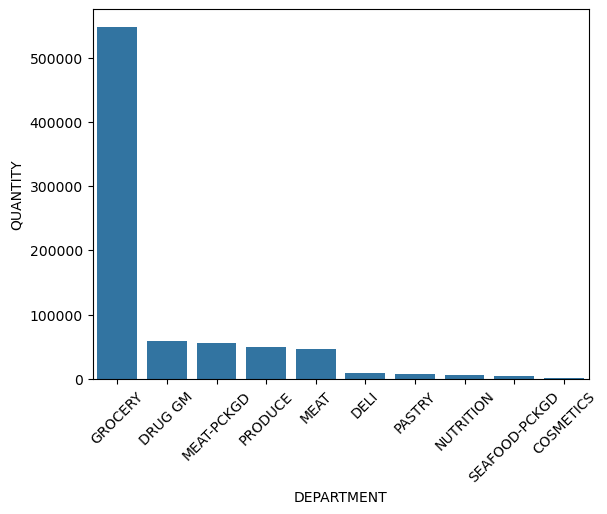

In [36]:
top_5_dept = df_agg.groupby('DEPARTMENT')['QUANTITY'].sum().reset_index()
top_5_dept = top_5_dept.sort_values(by='QUANTITY', ascending=False).head(10)


sns.barplot(data = top_5_dept, x = "DEPARTMENT", y = "QUANTITY")
plt.xticks(rotation = 45)
plt.show()

Counts for mailer:
 mailer
0    132
A    104
F     75
H     67
L     58
D     54
C     42
J     29
X     16
Z     10
Name: count, dtype: int64


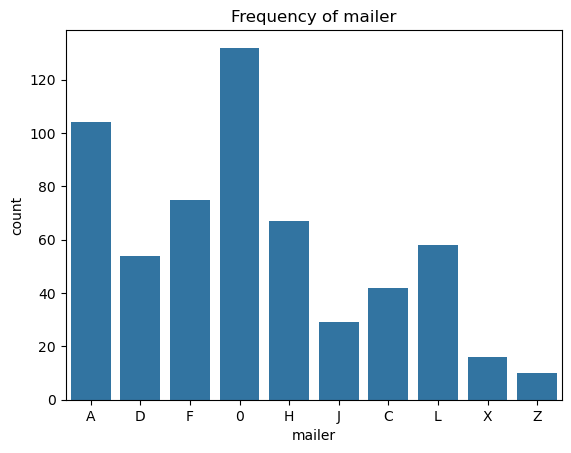

Counts for display:
 display
0    101
7     71
2     65
1     64
9     57
6     52
5     48
3     47
A     41
4     41
Name: count, dtype: int64


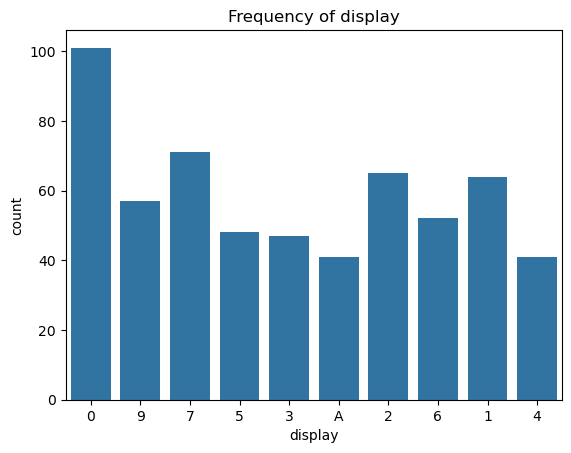

In [37]:
for col in ('mailer', 'display'):
    print(f"Counts for {col}:\n", df_agg[col].value_counts())
    sns.countplot(x=col, data=df_agg)
    plt.title(f'Frequency of {col}')
    plt.show()


### Data Analysis & Modelling

#### Statistical Analysis

Normality Test (Shapiro-Wilk):
  Group '0': p-value = 0.0
  Group '9': p-value = 0.0
  Group '7': p-value = 0.0
  Group '5': p-value = 0.0
  Group '3': p-value = 0.0
  Group 'A': p-value = 0.0
  Group '2': p-value = 0.0
  Group '6': p-value = 0.0
  Group '1': p-value = 0.0
  Group '4': p-value = 0.0

Generating Q-Q plots and distribution plots...
Saved Q-Q and distribution plots to C:\Users\Admin\Downloads\display_qq_and_distribution_4columns.png


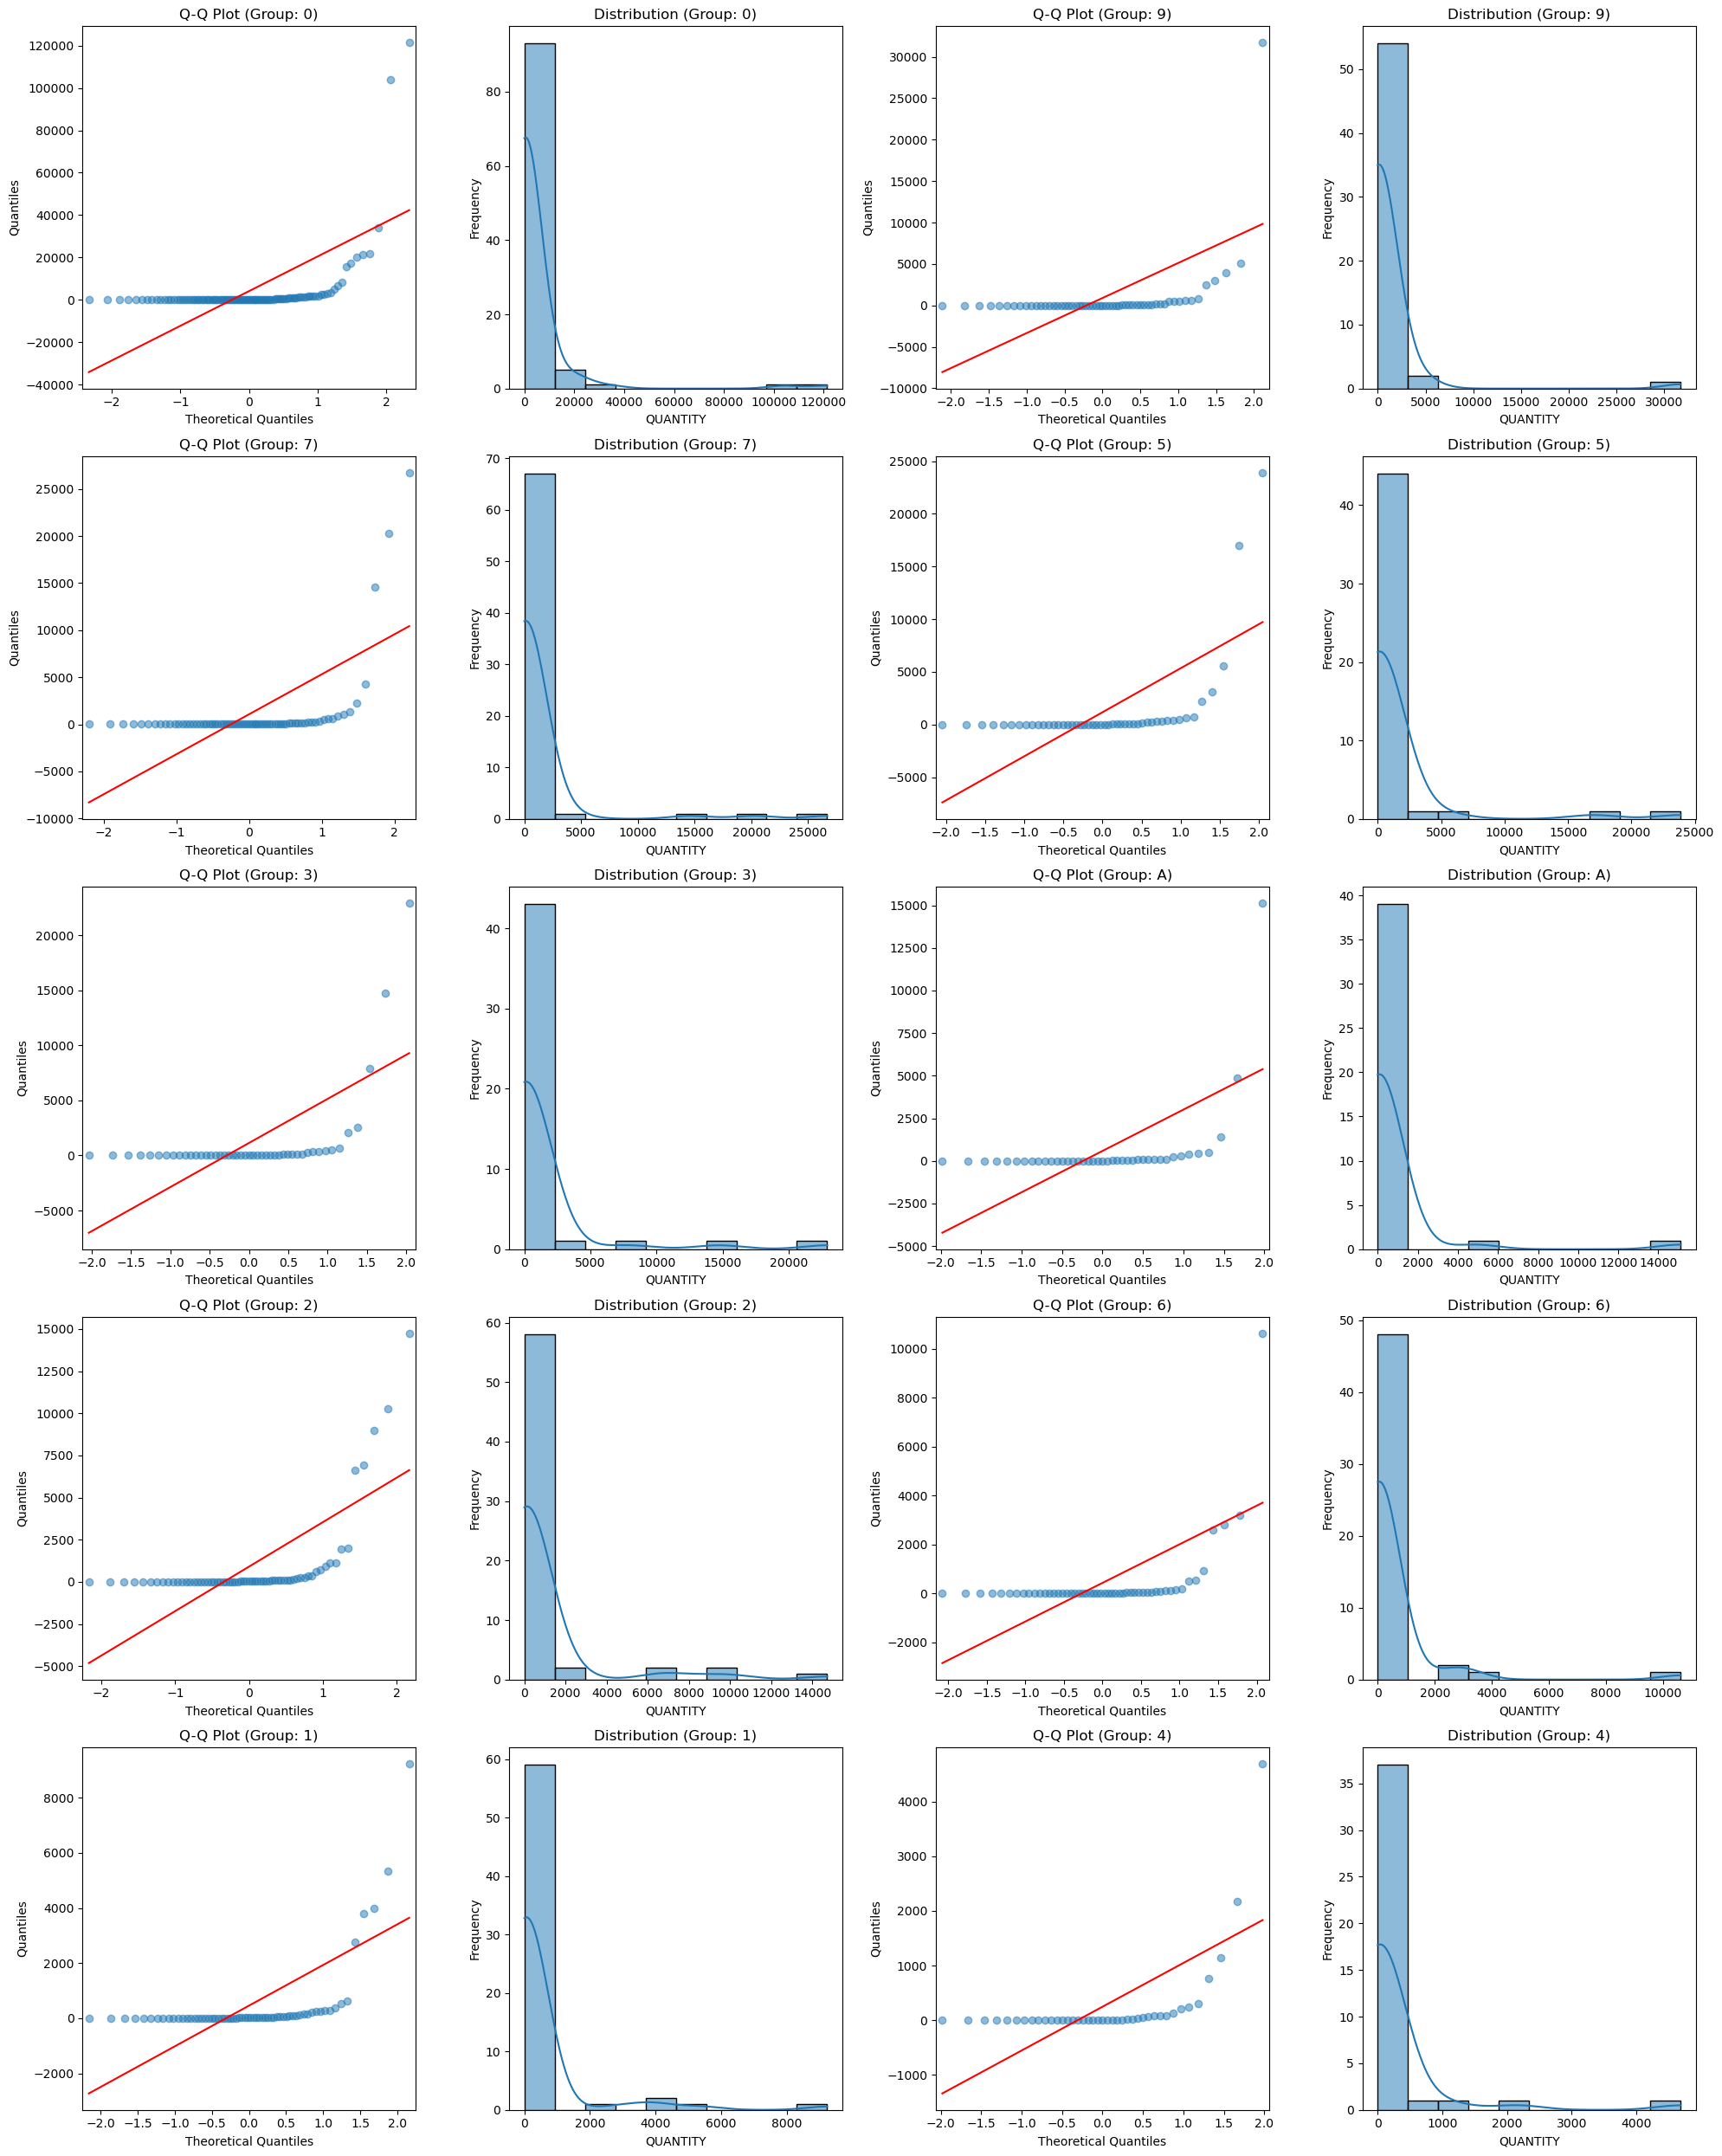


Levene's Test for Homogeneity of Variances: p-value = 0.05

Using Kruskal-Wallis:
  H-statistic = 30.0582, p-value = 0.0004

Summary of Results:
Normality Test (Shapiro-Wilk p-values):
  0: 0.0
  9: 0.0
  7: 0.0
  5: 0.0
  3: 0.0
  A: 0.0
  2: 0.0
  6: 0.0
  1: 0.0
  4: 0.0
Levene's Test (p-value): 0.05
Kruskal-Wallis Results:
  H-statistic: 30.0582
  p-value: 0.0004


In [40]:
# Initializing results dictionary
results = {}
groups = df_agg['display'].unique()

# Checking Normality (Shapiro-Wilk test for each group)
normality_results = {}
print("Normality Test (Shapiro-Wilk):")
for group in groups:
    stat, p_value = shapiro(df_agg[df_agg['display'] == group]['QUANTITY'])
    normality_results[group] = round(p_value, 2)
    print(f"  Group '{group}': p-value = {normality_results[group]}")
results['Normality Test (Shapiro-Wilk p-values)'] = normality_results

# Generating Q-Q Plots and Distribution Plots
print("\nGenerating Q-Q plots and distribution plots...")
num_groups = len(groups)
num_subplots = num_groups * 2 
rows = (num_subplots + 3) // 4 
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5)) 
axes = axes.flatten() 

# Generating the plots
for i, group in enumerate(groups):
    group_data = df_agg[df_agg['display'] == group]['QUANTITY']

    # Q-Q Plot
    sm.qqplot(group_data, line='s', ax=axes[i * 2], alpha=0.5)
    axes[i * 2].set_title(f"Q-Q Plot (Group: {group})")
    axes[i * 2].set_ylabel("Quantiles")
    axes[i * 2].set_xlabel("Theoretical Quantiles")

    # Distribution Plot
    sns.histplot(group_data, kde=True, ax=axes[i * 2 + 1], bins=10)
    axes[i * 2 + 1].set_title(f"Distribution (Group: {group})")
    axes[i * 2 + 1].set_xlabel("QUANTITY")
    axes[i * 2 + 1].set_ylabel("Frequency")

# Hiding any unused subplots
for j in range(num_groups * 2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Saving the plot for report
output_dir = r"C:\Users\Admin\Downloads" 
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, "display_qq_and_distribution_4columns.png")
fig.savefig(plot_file, dpi=300, bbox_inches="tight") 
print(f"Saved Q-Q and distribution plots to {plot_file}")

plt.show()


# Levene's Test for Homogeneity of Variances
levene_stat, levene_p_value = levene(
    *[df_agg[df_agg['display'] == group]['QUANTITY'] for group in groups]
)
levene_p_value = round(levene_p_value, 2)
print(f"\nLevene's Test for Homogeneity of Variances: p-value = {levene_p_value}")
results["Levene's Test (p-value)"] = levene_p_value

# Using Kruskal-Wallis
kruskal_stat, kruskal_p_value = kruskal(
    *[df_agg[df_agg['display'] == group]['QUANTITY'] for group in groups]
)
kruskal_stat, kruskal_p_value = round(kruskal_stat, 4), round(kruskal_p_value, 4)
print("\nUsing Kruskal-Wallis:")
print(f"  H-statistic = {kruskal_stat}, p-value = {kruskal_p_value}")
results['Kruskal-Wallis Results'] = {'H-statistic': kruskal_stat, 'p-value': kruskal_p_value}

# Printing results
print("\nSummary of Results:")
for key, value in results.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
        print(f"{key}: {value}")


In [41]:
import pandas as pd
import scikit_posthocs as sp

# Performing Dunn's test for pairwise comparisons with Bonferroni correction
dunn_results = sp.posthoc_dunn(df, val_col='QUANTITY', group_col='display', p_adjust='bonferroni')


dunn_results_rounded = dunn_results.round(4)  # Round p-values to 4 decimal places

# Extracting significant results (p < 0.05),
significant_results = []
for group1 in dunn_results_rounded.index:
    for group2 in dunn_results_rounded.columns:
        if group1 < group2 and dunn_results_rounded.loc[group1, group2] < 0.05:
            significant_results.append({
                'Group 1': group1,
                'Group 2': group2,
                'p-value (adjusted)': dunn_results_rounded.loc[group1, group2]
            })

# Converting results to a DataFrame
significant_results_df = pd.DataFrame(significant_results)

# Displaying the final table of significant pairwise comparisons
if not significant_results_df.empty:
    print("\nSignificant Pairwise Comparisons (Dunn's Test with Bonferroni correction):")
    print(significant_results_df)
else:
    print("\nNo significant pairwise differences found.")



Significant Pairwise Comparisons (Dunn's Test with Bonferroni correction):
   Group 1 Group 2  p-value (adjusted)
0        0       1              0.0069
1        0       2              0.0000
2        0       3              0.0000
3        0       4              0.0000
4        0       5              0.0000
5        0       6              0.0000
6        0       7              0.0001
7        0       9              0.0000
8        0       A              0.0000
9        1       3              0.0000
10       1       4              0.0000
11       1       5              0.0000
12       1       6              0.0000
13       1       9              0.0000
14       1       A              0.0000
15       2       3              0.0000
16       2       4              0.0000
17       2       5              0.0000
18       2       6              0.0000
19       2       7              0.0172
20       2       9              0.0000
21       2       A              0.0000
22       3       5         

Normality Test (Shapiro-Wilk):
  Group 'A': p-value = 0.0
  Group 'D': p-value = 0.0
  Group 'F': p-value = 0.0
  Group '0': p-value = 0.0
  Group 'H': p-value = 0.0
  Group 'J': p-value = 0.0
  Group 'C': p-value = 0.0
  Group 'L': p-value = 0.0
  Group 'X': p-value = 0.0
  Group 'Z': p-value = 0.0

Generating Q-Q plots and distribution plots...
Saved Q-Q and distribution plots to C:\Users\Admin\Downloads\mailer_qq_and_distribution_plots_4columns.png


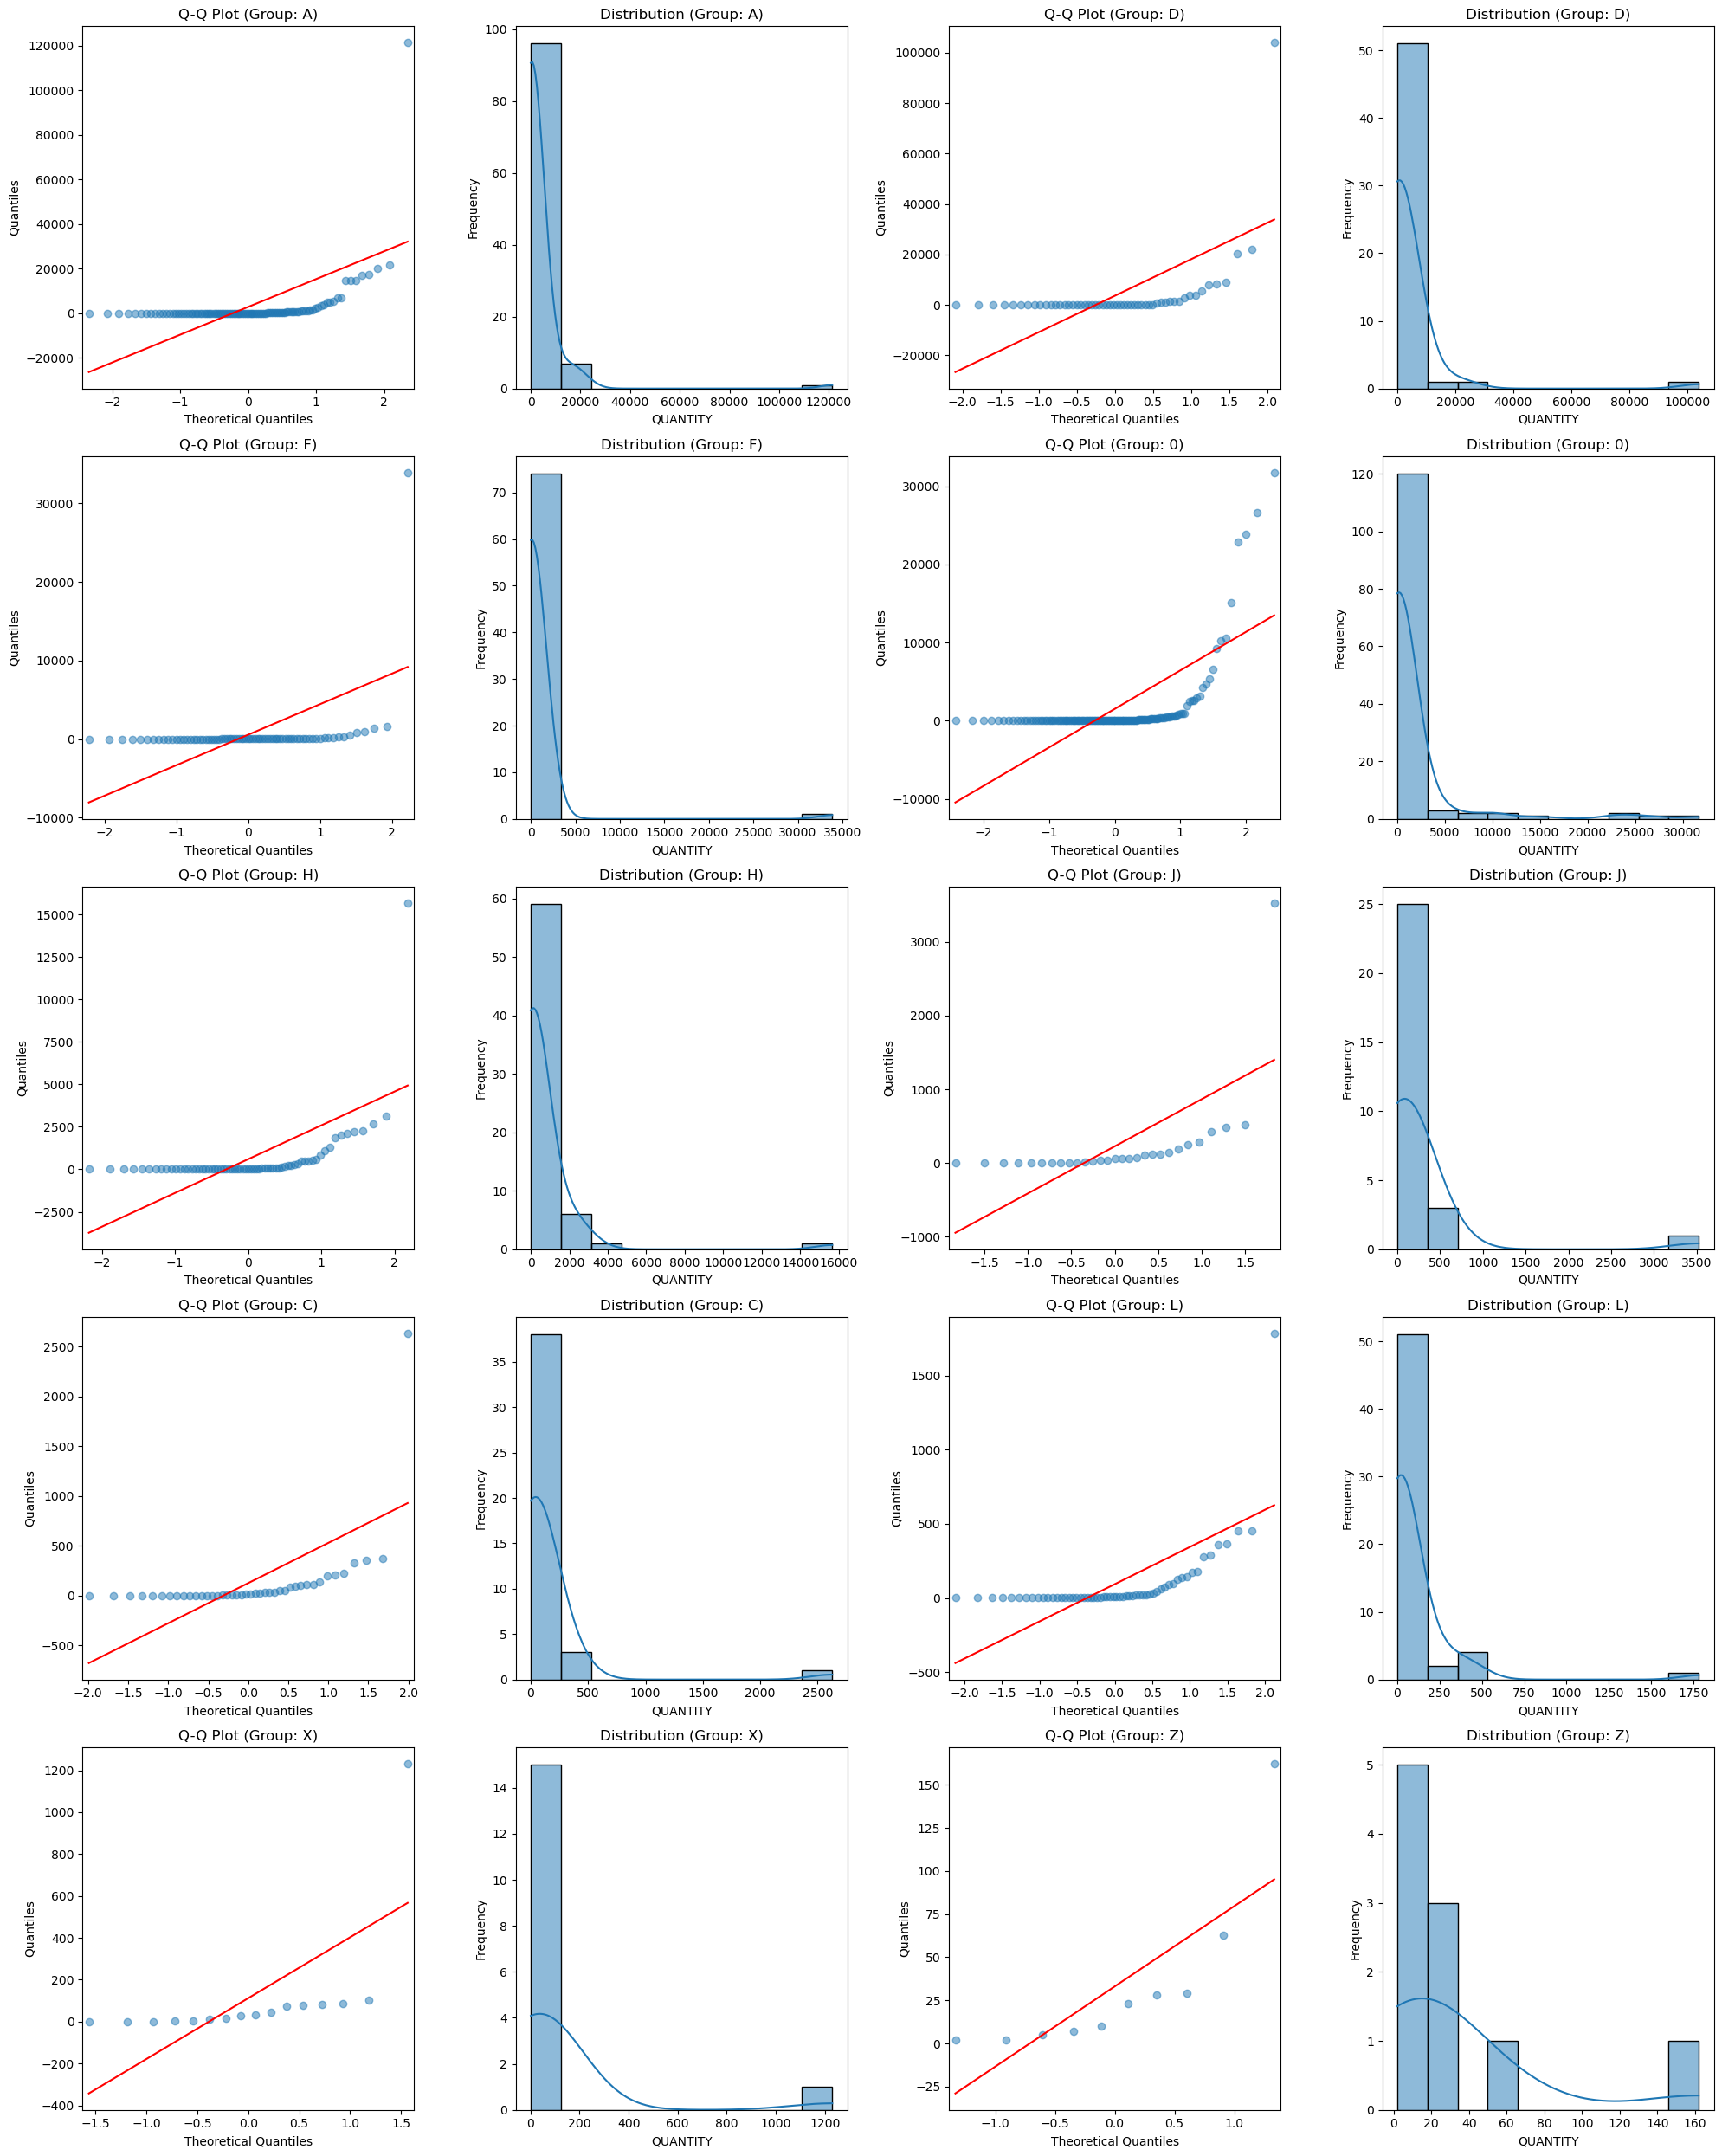


Levene's Test for Homogeneity of Variances: p-value = 0.09

Using Kruskal-Wallis:
  H-statistic = 17.5976, p-value = 0.0401

Summary of Results:
Normality Test (Shapiro-Wilk p-values):
  A: 0.0
  D: 0.0
  F: 0.0
  0: 0.0
  H: 0.0
  J: 0.0
  C: 0.0
  L: 0.0
  X: 0.0
  Z: 0.0
Levene's Test (p-value): 0.09
Kruskal-Wallis Results:
  H-statistic: 17.5976
  p-value: 0.0401


In [42]:
# Initializing results dictionary
results = {}
groups = df_agg['mailer'].unique()

# Checking Normality (Shapiro-Wilk test for each group)
normality_results = {}
print("Normality Test (Shapiro-Wilk):")
for group in groups:
    stat, p_value = shapiro(df_agg[df_agg['mailer'] == group]['QUANTITY'])
    normality_results[group] = round(p_value, 2)
    print(f"  Group '{group}': p-value = {normality_results[group]}")
results['Normality Test (Shapiro-Wilk p-values)'] = normality_results

# Generating Q-Q Plots and Distribution Plots
print("\nGenerating Q-Q plots and distribution plots...")
num_groups = len(groups)
num_subplots = num_groups * 2  
rows = (num_subplots + 3) // 4 
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))  
axes = axes.flatten()  

# Generating the plots
for i, group in enumerate(groups):
    group_data = df_agg[df_agg['mailer'] == group]['QUANTITY']

    # Q-Q Plot
    sm.qqplot(group_data, line='s', ax=axes[i * 2], alpha=0.5)
    axes[i * 2].set_title(f"Q-Q Plot (Group: {group})")
    axes[i * 2].set_ylabel("Quantiles")
    axes[i * 2].set_xlabel("Theoretical Quantiles")

    # Distribution Plot
    sns.histplot(group_data, kde=True, ax=axes[i * 2 + 1], bins=10)
    axes[i * 2 + 1].set_title(f"Distribution (Group: {group})")
    axes[i * 2 + 1].set_xlabel("QUANTITY")
    axes[i * 2 + 1].set_ylabel("Frequency")

# Hiding any unused subplots
for j in range(num_groups * 2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Saving the plot for report
output_dir = r"C:\Users\Admin\Downloads"  
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, "mailer_qq_and_distribution_plots_4columns.png")
fig.savefig(plot_file, dpi=300, bbox_inches="tight")  
print(f"Saved Q-Q and distribution plots to {plot_file}")

plt.show()

# Levene's Test for Homogeneity of Variances
levene_stat, levene_p_value = levene(
    *[df_agg[df_agg['mailer'] == group]['QUANTITY'] for group in groups]
)
levene_p_value = round(levene_p_value, 2)
print(f"\nLevene's Test for Homogeneity of Variances: p-value = {levene_p_value}")
results["Levene's Test (p-value)"] = levene_p_value

# Using Kruskal-Wallis Test
kruskal_stat, kruskal_p_value = kruskal(
    *[df_agg[df_agg['mailer'] == group]['QUANTITY'] for group in groups]
)
kruskal_stat, kruskal_p_value = round(kruskal_stat, 4), round(kruskal_p_value, 4)
print("\nUsing Kruskal-Wallis:")
print(f"  H-statistic = {kruskal_stat}, p-value = {kruskal_p_value}")
results['Kruskal-Wallis Results'] = {'H-statistic': kruskal_stat, 'p-value': kruskal_p_value}

#  Printing results
print("\nSummary of Results:")
for key, value in results.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
        print(f"{key}: {value}")


In [43]:
# Performing Dunn's test for pairwise comparisons with Bonferroni correction
dunn_results = sp.posthoc_dunn(df_agg, val_col='QUANTITY', group_col='mailer', p_adjust='bonferroni')


dunn_results_rounded = dunn_results.round(4)

# Extracting significant results (p < 0.05),
significant_results = []
for group1 in dunn_results_rounded.index:
    for group2 in dunn_results_rounded.columns:
        if group1 < group2 and dunn_results_rounded.loc[group1, group2] < 0.05:
            significant_results.append({
                'Group 1': group1,
                'Group 2': group2,
                'p-value (adjusted)': dunn_results_rounded.loc[group1, group2]
            })

# Converting results to a DataFrame
significant_results_df = pd.DataFrame(significant_results)

# Displaying the final table of significant pairwise comparisons
if not significant_results_df.empty:
    print("\nSignificant Pairwise Comparisons (Dunn's Test with Bonferroni correction):")
    print(significant_results_df)
else:
    print("\nNo significant pairwise differences found.")



No significant pairwise differences found.


#### Predictive Modeling

In [45]:
# Filtering top departments based on total quantity sold
top_departments = df_agg.groupby('DEPARTMENT')['QUANTITY'].sum().nlargest(5).index
df_filtered = df_agg[df_agg['DEPARTMENT'].isin(top_departments)]

# Adding interaction terms
df_filtered['interaction_display_mailer'] = df_filtered['display_bin'] * df_filtered['mailer_bin']
df_filtered['interaction_department_display'] = df_filtered['DEPARTMENT'].astype('category').cat.codes * df_filtered['display_bin']
df_filtered['interaction_department_mailer'] = df_filtered['DEPARTMENT'].astype('category').cat.codes * df_filtered['mailer_bin']

# One-hot encoding all categorical variables
df_encoded = pd.get_dummies(df_filtered, columns=['DEPARTMENT', 'display', 'mailer'], drop_first=True)

# Verifying the binary columns are numeric
if 'display_bin' in df_encoded and 'mailer_bin' in df_encoded:
    df_encoded['display_bin'] = df_encoded['display_bin'].astype(float)
    df_encoded['mailer_bin'] = df_encoded['mailer_bin'].astype(float)

# Log-transforming the target variable
df_encoded['QUANTITY_LOG'] = np.log1p(df_encoded['QUANTITY'])

# Defining features and target
X = df_encoded.drop(columns=['QUANTITY', 'QUANTITY_LOG', 'PRODUCT_ID'], errors='ignore')
y = df_encoded['QUANTITY_LOG']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initializing models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=40)
}

# Training and evaluating models
results = {}

print("Results for Log-Transformed 'QUANTITY':")
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 * (1 - mape)  # Convert MAPE to accuracy
    
    results[name] = {"MSE": mse, "R2": r2, "Accuracy": accuracy}
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}, Accuracy: {accuracy:.2f}%")

Results for Log-Transformed 'QUANTITY':
Linear Regression - MSE: 1.65, R2: 0.76, Accuracy: 58.08%
Decision Tree - MSE: 3.01, R2: 0.56, Accuracy: 53.78%
Random Forest - MSE: 1.64, R2: 0.76, Accuracy: 66.10%
XGBoost - MSE: 1.22, R2: 0.82, Accuracy: 73.00%


In [46]:
# Defining hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [30,35,40,45],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01,0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Initializing XGBoost model
xgb = XGBRegressor(random_state=42)

# Initializing GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Performing GridSearchCV
print("Performing hyperparameter tuning for XGBoost...")
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negated because scoring='neg_mean_squared_error'

print(f"Best Parameters for XGBoost: {best_params}")
print(f"Best MSE (Cross-Validated): {best_score:.2f}")

# Training XGBoost model with best parameters
best_xgb = XGBRegressor(random_state=42, **best_params)
best_xgb.fit(X_train, y_train)

# Predicting and evaluating the best model
y_pred_best_xgb = best_xgb.predict(X_test)
best_xgb_mse = mean_squared_error(y_test, y_pred_best_xgb)
best_xgb_r2 = r2_score(y_test, y_pred_best_xgb)
best_xgb_mape = mean_absolute_percentage_error(y_test, y_pred_best_xgb)
best_xgb_accuracy = 100 * (1 - best_xgb_mape)

print(f"Optimized XGBoost - MSE: {best_xgb_mse:.2f}, R2: {best_xgb_r2:.2f}, Accuracy: {best_xgb_accuracy:.2f}%")

# Extracting feature importance from the optimized XGBoost model
xgb_feature_importance = pd.Series(best_xgb.feature_importances_, index=X.columns)
top_features_xgb = xgb_feature_importance.sort_values(ascending=False).head(10)

print("\nTop 10 Important Features from Optimized XGBoost:")
print(top_features_xgb)

Performing hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 45, 'subsample': 0.8}
Best MSE (Cross-Validated): 1.39
Optimized XGBoost - MSE: 1.03, R2: 0.85, Accuracy: 75.02%

Top 10 Important Features from Optimized XGBoost:
interaction_display_mailer        0.247430
mailer_A                          0.089298
display_2                         0.058742
mailer_D                          0.055498
interaction_department_display    0.054567
mailer_Z                          0.042425
mailer_X                          0.040709
mailer_H                          0.038595
DEPARTMENT_GROCERY                0.036714
DEPARTMENT_MEAT-PCKGD             0.032687
dtype: float32


### Performance Analysis & Results


Performance Metrics for Optimized XGBoost Model:
Mean Squared Error (MSE): 1.0349
R-squared (R2): 0.8503
Mean Absolute Error (MAE): 0.7176
Mean Absolute Percentage Error (MAPE): 0.2498
Accuracy: 75.02%
Combined plot saved to C:\Users\Admin\Downloads\combined_xgboost_plots.png


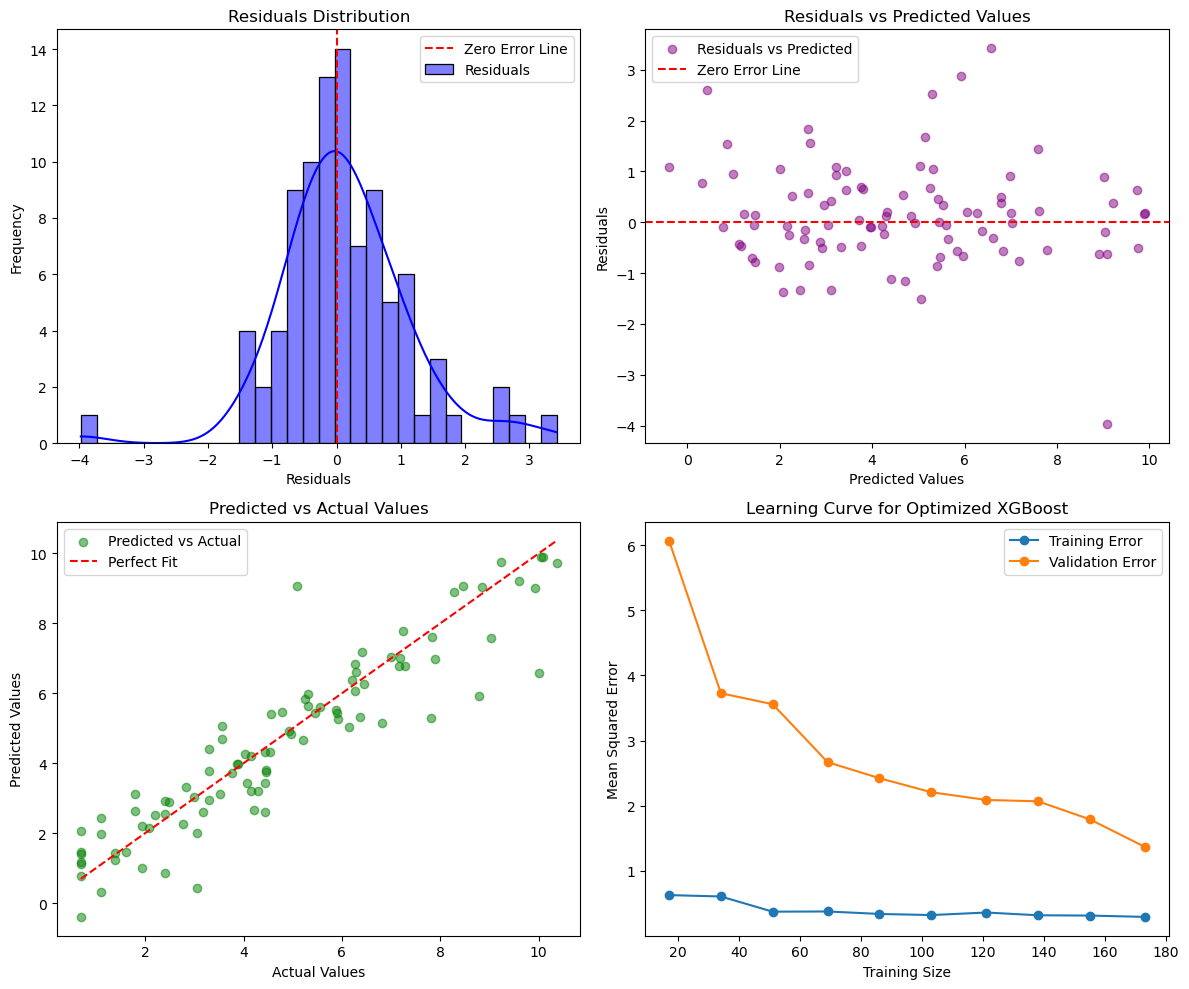

In [48]:
# Calculating Performance Metrics 
y_pred_best_xgb = best_xgb.predict(X_test)
best_xgb_mse = mean_squared_error(y_test, y_pred_best_xgb)
best_xgb_r2 = r2_score(y_test, y_pred_best_xgb)
best_xgb_mae = mean_absolute_error(y_test, y_pred_best_xgb)
best_xgb_mape = mean_absolute_percentage_error(y_test, y_pred_best_xgb)
best_xgb_accuracy = 100 * (1 - best_xgb_mape)

# Calculating residuals
residuals = y_test - y_pred_best_xgb

# Checking overfitting using Learning Curve 
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Printing performance metrics
print("\nPerformance Metrics for Optimized XGBoost Model:")
print(f"Mean Squared Error (MSE): {best_xgb_mse:.4f}")
print(f"R-squared (R2): {best_xgb_r2:.4f}")
print(f"Mean Absolute Error (MAE): {best_xgb_mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {best_xgb_mape:.4f}")
print(f"Accuracy: {best_xgb_accuracy:.2f}%")

# Creating Subplots for the graphs and report
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() 

# Residuals Distribution
sns.histplot(residuals, kde=True, bins=30, ax=axes[0], color='blue', label='Residuals')
axes[0].axvline(0, color='red', linestyle='--', label='Zero Error Line')
axes[0].set_title('Residuals Distribution')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Residuals vs Predicted Values
axes[1].scatter(y_pred_best_xgb, residuals, alpha=0.5, label='Residuals vs Predicted', color='purple')
axes[1].axhline(0, color='red', linestyle='--', label='Zero Error Line')
axes[1].set_title('Residuals vs Predicted Values')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].legend()

# Predicted vs Actual Values
axes[2].scatter(y_test, y_pred_best_xgb, alpha=0.5, label='Predicted vs Actual', color='green')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
axes[2].set_title('Predicted vs Actual Values')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')
axes[2].legend()

# Learning Curve
axes[3].plot(train_sizes, train_scores_mean, 'o-', label="Training Error")
axes[3].plot(train_sizes, test_scores_mean, 'o-', label="Validation Error")
axes[3].set_title("Learning Curve for Optimized XGBoost")
axes[3].set_xlabel("Training Size")
axes[3].set_ylabel("Mean Squared Error")
axes[3].legend()

plt.tight_layout()

# Saving the subplot for report
output_dir = r"C:\Users\Admin\Downloads" 
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, "combined_xgboost_plots.png")
fig.savefig(plot_file, dpi=300, bbox_inches="tight") 
print(f"Combined plot saved to {plot_file}")

# Show the combined figure
plt.show()


Combined feature importance plot saved to C:\Users\Admin\Downloads\feature_importance_combined.png


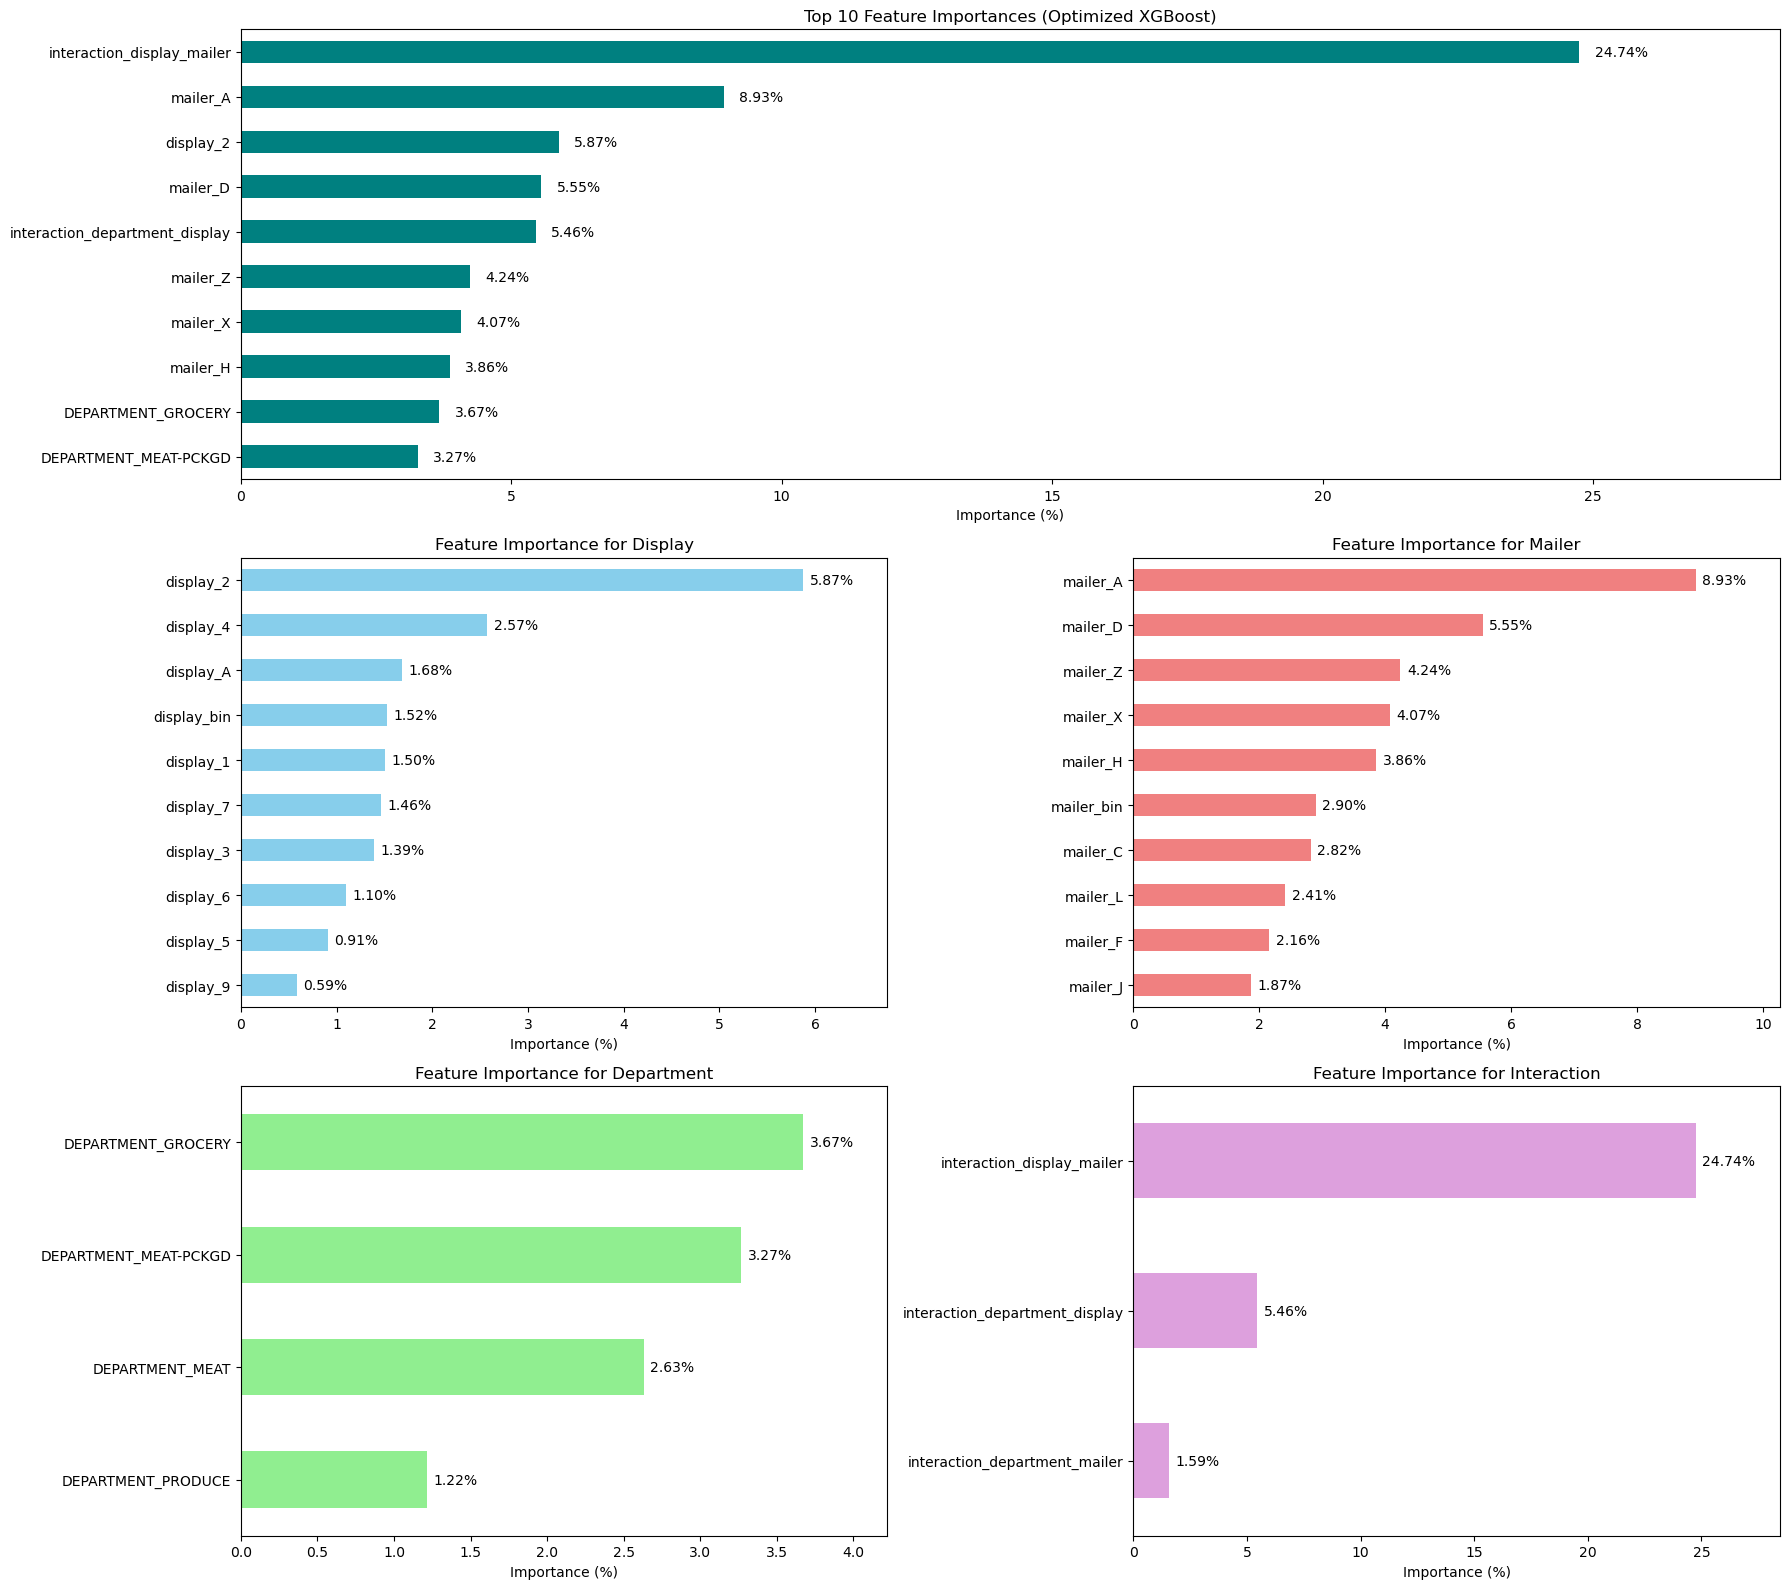

In [49]:
# Converting feature importance scores into percentages and sorting
xgb_feature_importance_percent = (xgb_feature_importance / xgb_feature_importance.sum()) * 100
top_features_xgb = xgb_feature_importance_percent.sort_values(ascending=False).head(10)

# Extracting features by categories
display_features = xgb_feature_importance_percent[xgb_feature_importance_percent.index.str.startswith('display_')]
mailer_features = xgb_feature_importance_percent[xgb_feature_importance_percent.index.str.startswith('mailer_')]
dept_features = xgb_feature_importance_percent[xgb_feature_importance_percent.index.str.startswith('DEPARTMENT_')]
int_features = xgb_feature_importance_percent[xgb_feature_importance_percent.index.str.startswith('interaction_')]

# Sorting each category
display_features_sorted = display_features.sort_values(ascending=True)
mailer_features_sorted = mailer_features.sort_values(ascending=True)
dept_features_sorted = dept_features.sort_values(ascending=True)
int_features_sorted = int_features.sort_values(ascending=True)
top_features_sorted = top_features_xgb.sort_values(ascending=True)

# Creating Subplots for the graphs and report
fig = plt.figure(figsize=(18, 16))  
gs = GridSpec(3, 2, figure=fig, width_ratios=[1.5, 1.5])  

# Function to add and format data labels
def add_bar_labels(ax, data, buffer=0.15):
    xlim_max = data.max() * (1 + buffer)  
    ax.set_xlim(0, xlim_max) 
    for index, value in enumerate(data):
        ax.text(value + (xlim_max * 0.01), index, f"{value:.2f}%", va='center', ha='left')  

# Top 10 important features
ax0 = fig.add_subplot(gs[0, :]) 
top_features_sorted.plot(kind='barh', color='teal', ax=ax0)
ax0.set_title('Top 10 Feature Importances (Optimized XGBoost)')
ax0.set_xlabel('Importance (%)')
add_bar_labels(ax0, top_features_sorted)

# Display features
ax1 = fig.add_subplot(gs[1, 0]) 
display_features_sorted.plot(kind='barh', color='skyblue', ax=ax1)
ax1.set_title('Feature Importance for Display')
ax1.set_xlabel('Importance (%)')
add_bar_labels(ax1, display_features_sorted)

# Mailer features
ax2 = fig.add_subplot(gs[1, 1])  
mailer_features_sorted.plot(kind='barh', color='lightcoral', ax=ax2)
ax2.set_title('Feature Importance for Mailer')
ax2.set_xlabel('Importance (%)')
add_bar_labels(ax2, mailer_features_sorted)

# Department features
ax3 = fig.add_subplot(gs[2, 0])  
dept_features_sorted.plot(kind='barh', color='lightgreen', ax=ax3)
ax3.set_title('Feature Importance for Department')
ax3.set_xlabel('Importance (%)')
add_bar_labels(ax3, dept_features_sorted)

# Interaction features
ax4 = fig.add_subplot(gs[2, 1]) 
int_features_sorted.plot(kind='barh', color='plum', ax=ax4)
ax4.set_title('Feature Importance for Interaction')
ax4.set_xlabel('Importance (%)')
add_bar_labels(ax4, int_features_sorted)


plt.tight_layout()

# Saving the subplot for report
output_dir = r"C:\Users\Admin\Downloads"  
os.makedirs(output_dir, exist_ok=True)
plot_file = os.path.join(output_dir, "feature_importance_combined.png")
fig.savefig(plot_file, dpi=300, bbox_inches="tight")
print(f"Combined feature importance plot saved to {plot_file}")

# Show the combined plot
plt.show()
